In [1]:
import sys
sys.path.append("/Users/coffee/Documents/code/QkidsAutomation")
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, scale, MinMaxScaler
import pandas as pd
from teacher_predict.DataFarm import aggregate
import matplotlib.pyplot as plt
from qkids import Week
import datetime
import random
import numpy as np

# 加载数据

In [2]:
base_dir = "/Users/coffee/Documents/code/QkidsAutomation/teacher_predict"
raw = pd.read_pickle(base_dir + '/new_historical.pkl')
student_cnt = pd.read_pickle(base_dir + '/active_student.pkl')

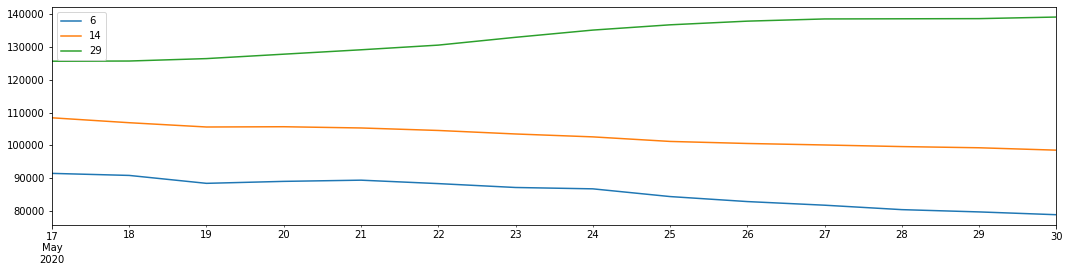

In [3]:
index = 15
student_cnt.iloc[-index:-index+14].plot(figsize=(18,4))

## 两周前周末的数据

In [5]:
# student_cnt['date'] = student_cnt.index + datetime.timedelta(days=14)
# student_cnt['yearweek'] = student_cnt.date.apply(lambda x: x.strftime("%Y%W") ) 
# student_cnt['dayofweek'] = student_cnt.date.apply(lambda x: x.dayofweek ) 
# week_student_cnt = student_cnt.loc[student_cnt.dayofweek == 6, [14, 'yearweek']]

In [8]:
# week_student_cnt = week_student_cnt.set_index('yearweek').iloc[:,0]

In [10]:
# week_student_cnt['201802'] = 41038
# week_student_cnt['201801'] = 40000

In [4]:
# (week_student_cnt - week_student_cnt.mean())/ week_student_cnt.std()

# 数据预处理

## 老师数

In [5]:
data = aggregate(raw)

In [6]:
data.head()

,student_count,teacher_count
begin,,
2018-01-01 18:30:00,1173.0,242.0
2018-01-01 19:10:00,1573.0,319.0
2018-01-01 19:50:00,1706.0,348.0
2018-01-01 20:30:00,1322.0,268.0
2018-01-02 18:30:00,1560.0,312.0


## 时间点

In [7]:
SLOTS = [
    datetime.time(8, 30),
    datetime.time(9, 10),
    datetime.time(9, 50),
    datetime.time(10, 30),
    datetime.time(11, 10),
    datetime.time(11, 50),
    datetime.time(17, 50),
    datetime.time(18, 30),
    datetime.time(19, 10),
    datetime.time(19, 50),
    datetime.time(20, 30)
]

In [8]:
def process_data(data):
    data.loc[:,'date'] = [ i.date() for i in data.index]
    slot_num = data.groupby('date').count().iloc[:, 0]
    data.loc[:, 'slot_num'] = data.date.apply(lambda x: slot_num[x])
    data.loc[:,'time'] = [ i.time() for i in data.index]
    data.loc[:,'yearweek'] = [ i.strftime("%Y%W") for i in data.index]
    data.loc[:,'dayofweek'] = [ i.dayofweek for i in data.index]
    c = data.time.isin(SLOTS)
    data = data.loc[c]
    data.loc[:, 'slot'] = data.time.apply(lambda x:SLOTS.index(x))
    data.loc[:, 'active_student_cnt'] = data.date.apply(lambda x: student_cnt.iloc[:,1].get(x, 1))
    
    time_onehot = pd.get_dummies(data.time)
    dayofweek_onehot = pd.get_dummies(data.dayofweek)
    slot_num_onehot = pd.get_dummies(data.slot_num)
    std_data = data[['student_count', 'teacher_count', 'active_student_cnt']].apply(lambda x: (x - x.mean()) / x.std() )
    sample = pd.concat([std_data, time_onehot, dayofweek_onehot, slot_num_onehot], axis=1)
    return sample

In [9]:
sample = process_data(data)

/Users/coffee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coffee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [80]:
data.loc['2020-05-25 00:00:00':'2020-05-25 23:00:00']

,student_count,teacher_count,date,slot_num,time,yearweek,dayofweek
begin,,,,,,,
2020-05-25 08:30:00,867.0,264.0,2020-05-25,11,08:30:00,202021,0
2020-05-25 09:10:00,1316.0,376.0,2020-05-25,11,09:10:00,202021,0
2020-05-25 09:50:00,1552.0,441.0,2020-05-25,11,09:50:00,202021,0
2020-05-25 10:30:00,1626.0,451.0,2020-05-25,11,10:30:00,202021,0
2020-05-25 11:10:00,1463.0,407.0,2020-05-25,11,11:10:00,202021,0
2020-05-25 11:50:00,837.0,240.0,2020-05-25,11,11:50:00,202021,0
2020-05-25 17:50:00,1221.0,330.0,2020-05-25,11,17:50:00,202021,0
2020-05-25 18:30:00,3213.0,895.0,2020-05-25,11,18:30:00,202021,0
2020-05-25 19:10:00,5072.0,1484.0,2020-05-25,11,19:10:00,202021,0


In [11]:
sample

,student_count,teacher_count,active_student_cnt,08:30:00,09:10:00,09:50:00,10:30:00,11:10:00,11:50:00,17:50:00,...,3,4,5,6,8,9,10,11,15,17
begin,,,,,,,,,,,,,,,,,,,,,
2018-01-01 18:30:00,-1.191314,-1.414542,-1.861916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2018-01-01 19:10:00,-0.964911,-1.259186,-1.861916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2018-01-01 19:50:00,-0.889632,-1.200675,-1.861916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2018-01-01 20:30:00,-1.106979,-1.362084,-1.861916,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2018-01-02 18:30:00,-0.972269,-1.273309,-1.850140,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 17:50:00,-1.462998,-1.521476,0.215730,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2020-05-31 18:30:00,-0.810957,-0.902068,0.215730,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-31 19:10:00,0.361244,0.433592,0.215730,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### one hot

In [12]:
def generate_data(data, sample, shuffle=False):
    yearweek = data.yearweek.unique()
    length = list(range(1, len(yearweek)))
    while 1:
        if shuffle:
            random.shuffle(length)
        for i in length:
            weeks = yearweek[-i:]
            c = data.yearweek.isin(weeks)
            train = sample.loc[c]
            yield train.iloc[:, 2:].values, [train.student_count.values, train.teacher_count.values]

In [13]:
split_day = '2020-05-25 00:00:00'
train_gen = generate_data(data[:split_day], sample[:split_day], False)
validation, validation_student, validation_teacher = sample.loc[split_day:], sample.student_count.loc[split_day:].values, sample.teacher_count.loc[split_day:].values
validation = validation.iloc[:, 2:].values
train = sample[:split_day]
train = train.iloc[:, 2:].values
train_student, train_teacher = sample.student_count.loc[:split_day].values, sample.teacher_count.loc[:split_day].values

In [14]:
sample.shape

(6004, 32)

In [15]:
next_week_active_student_cnt  = sample.iloc[-1, 2]

In [16]:
asc = pd.DataFrame(sample.iloc[:,2], index=  sample.index)
asc['date'] = [ tim + datetime.timedelta(days=14) for tim in asc.index]
def isoYW(time):
    year, week, weekday = time.isocalendar()
    return '%d%02d' % (year, week)

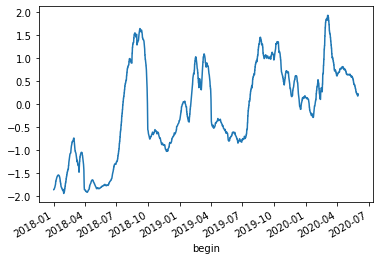

In [54]:
asc.active_student_cnt.plot()

In [17]:
asc['yearofweek'] = asc.date.apply(isoYW) 
asc['dayofweek'] = asc.date.apply(lambda x: x.dayofweek ) 

In [18]:
wasc = asc.loc[asc.dayofweek ==6, ['active_student_cnt', 'yearofweek'] ]
wasc = wasc.set_index('yearofweek').iloc[:, 0]
wasc.drop_duplicates(inplace=True)
wasc['201802'] = -1.692292
wasc['201801'] = -1.728309

In [19]:
sample['active_student_cnt'] = [ wasc[isoYW(i)] for i in sample.index]

In [78]:
sample.loc['2020-05-25 00:00:00':'2020-05-31 23:00:00']

,student_count,teacher_count,active_student_cnt,08:30:00,09:10:00,09:50:00,10:30:00,11:10:00,11:50:00,17:50:00,...,3,4,5,6,8,9,10,11,15,17
2020-05-25 08:30:00,-1.312001,-1.315178,0.296058,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-25 09:10:00,-1.062415,-1.093533,0.296058,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-25 09:50:00,-0.931229,-0.964899,0.296058,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-25 10:30:00,-0.890094,-0.945109,0.296058,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-25 11:10:00,-0.980701,-1.032184,0.296058,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 17:50:00,-1.408723,-1.463601,0.248663,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2020-05-31 18:30:00,-0.768358,-0.856055,0.248663,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-31 19:10:00,0.382853,0.454028,0.248663,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-05-31 19:50:00,0.774743,0.818160,0.248663,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 模型

In [21]:
def create_model(width):
    data_input = tf.keras.Input(shape=[width], name='date')
    # layer = tf.keras.layers.Dense(units=77, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(data_input)
    layer = tf.keras.layers.Dense(units=77, activation='relu')(data_input)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    # layer = tf.keras.layers.Dense(units=77, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(layer)
    layer = tf.keras.layers.Dense(units=77, activation='relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    student_predict_layer = tf.keras.layers.Dense(units=1, name='student')(layer)
    teacher_predict_layer = tf.keras.layers.Dense(units=1, name='teacher')(layer)
    return tf.keras.models.Model(data_input, [student_predict_layer, teacher_predict_layer])
api_model = create_model(train.shape[1])

In [22]:
api_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = ['mae', 'mae'])

In [23]:
epochs = 420

In [24]:
sw = np.arange(start = 0.01, stop= 1, step=0.99 / len(train_teacher) )

In [25]:
history = api_model.fit(
    train, [train_student, train_teacher], epochs=epochs, sample_weight=[sw, sw],
    batch_size = 154,
    validation_data=(validation, [validation_student, validation_teacher]),
    shuffle=True,verbose=False,
)

### 可视化

In [26]:
def show_history(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    head = 10
    epochs_range = range(epochs-head)
    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(epochs_range, loss[head:],'bo', label='Training Loss')
    ax1.plot(epochs_range, val_loss[head:],'r', label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation Loss')
    

    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(epochs_range, history.history['student_loss'][head:],'bo', label='Training Loss')
    ax2.plot(epochs_range, history.history['val_student_loss'][head:],'r', label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('student Training and Validation Loss')
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(epochs_range, history.history['teacher_loss'][head:],'bo', label='Training Loss')
    ax3.plot(epochs_range, history.history['val_teacher_loss'][head:],'r', label='Validation Loss')
    ax3.legend(loc='upper right')
    ax3.set_title('Teacher Training and Validation Loss')

    plt.show()
    
def show_history_teacher(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    head = 10
    epochs = len(loss)
    epochs_range = range(epochs-head)
    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(epochs_range, loss[head:],'bo', label='Training Loss')
    ax1.plot(epochs_range, val_loss[head:],'r', label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('Teacher Training and Validation Loss')
    
def show_predict(predict, actual):
    plt.figure(1, figsize=(18, 16))
    length = range(len(actual[0]))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(length, predict[0].flatten(), 'r*', label='predict')
    ax1.bar(length, actual[0], label='actual')
    ax1.legend(loc='upper right')
    ax1.set_title('student predict and actual')
    
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(length, predict[1].flatten(),'r*', label='predict')
    ax2.bar(length, actual[1], label='actual')
    ax2.legend(loc='upper right')
    ax2.set_title('teacher predict and actual')
    
def show_predict_teacher(predict, actual):
    plt.figure(1, figsize=(16, 8))
    length = range(len(actual))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(length, predict, 'r*', label='predict')
    ax1.bar(length, actual, label='actual')
    ax1.legend(loc='upper right')
    ax1.set_title('Teacher predict and actual')

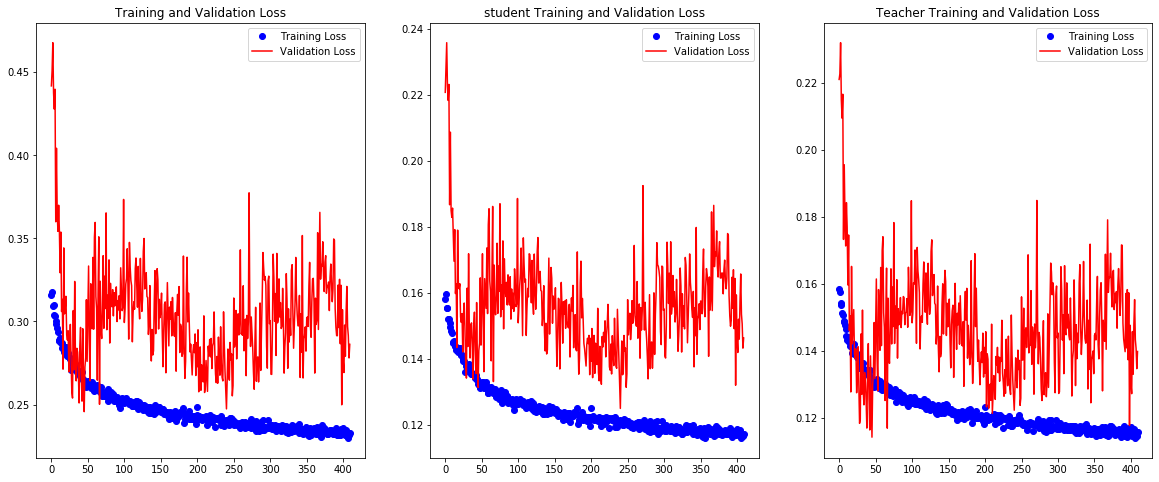

In [27]:
show_history(history, epochs)

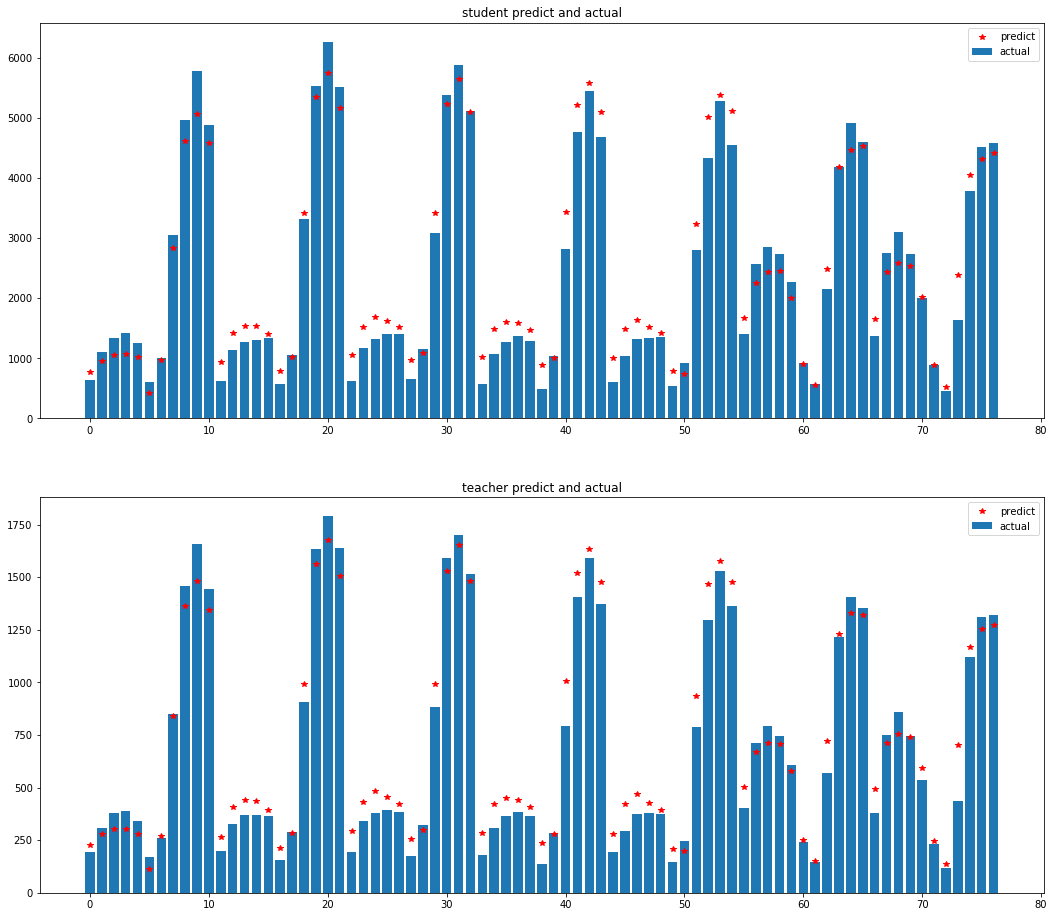

In [28]:
a = api_model.predict(validation)
student_std, student_mean = data.student_count.std(), data.student_count.mean()
a[0] = a[0] * student_std + student_mean 
validation_student_v = validation_student * student_std + student_mean
teacher_std, teacher_mean = data.teacher_count.std(), data.teacher_count.mean()
a[1] = a[1] * teacher_std + teacher_mean 
validation_teacher_v = validation_teacher * teacher_std + teacher_mean
show_predict(a, [validation_student_v,validation_teacher_v ])

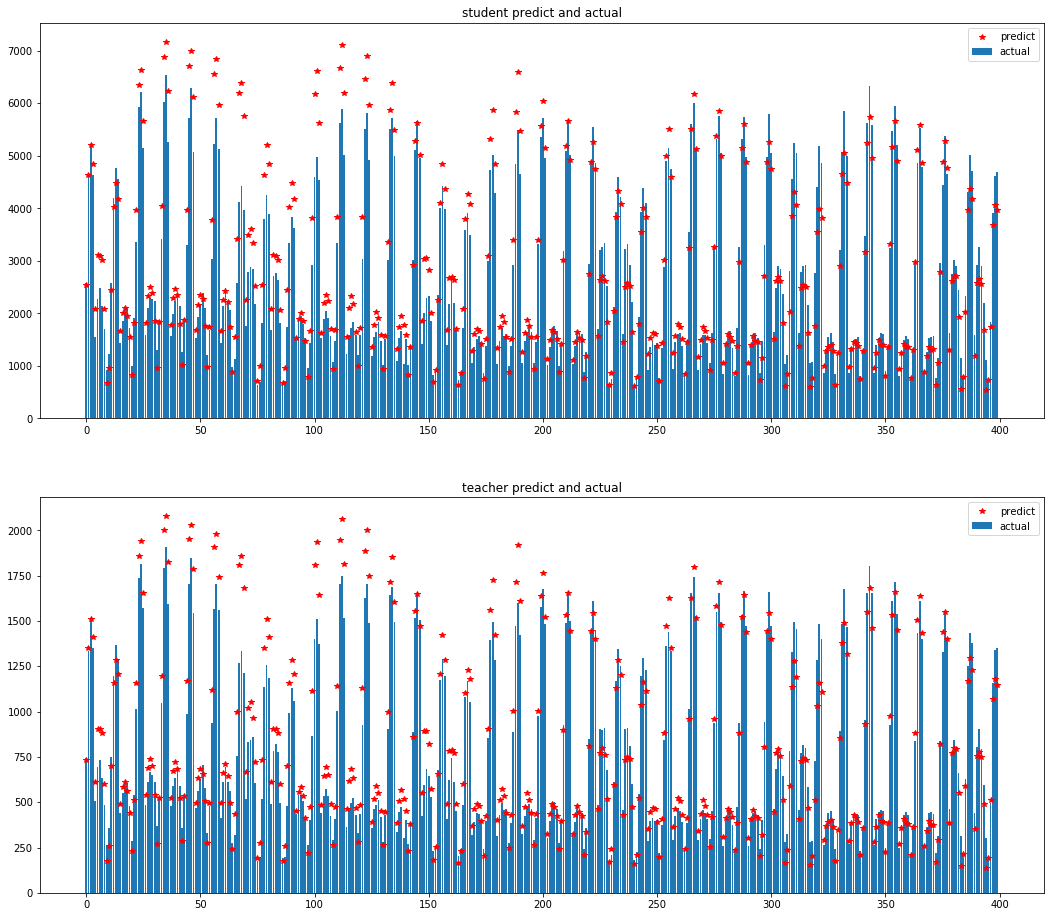

In [29]:
index = 400
show_data = sample.iloc[-index:, 2:].values
a = api_model.predict(show_data)
a[0] = a[0] * student_std + student_mean
a[1] = a[1] * teacher_std + teacher_mean 
validation_student_v = data.student_count.iloc[-index:].values
validation_teacher_v = data.teacher_count.iloc[-index:].values
show_predict(a, [validation_student_v,validation_teacher_v ])

# 保存模型

In [47]:
api_model.save('schedule.202024.h5')

# 预测
## 全训练

In [30]:
all_train = sample.iloc[:, 2:].values
all_train_student, all_train_teacher = sample.student_count.values, sample.teacher_count.values
model = create_model(all_train.shape[1])

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = ['mae', 'mae'])

In [32]:
asw = np.arange(start = 0.5, stop= 1, step=0.5 / len(all_train_teacher) )

In [33]:
epochs=420

In [34]:
history = model.fit(
    all_train, [all_train_student, all_train_teacher], epochs=epochs, sample_weight=[asw, asw],
    batch_size = 154,
    validation_data=(validation, [validation_student, validation_teacher]),
    shuffle=True,verbose=False,
)

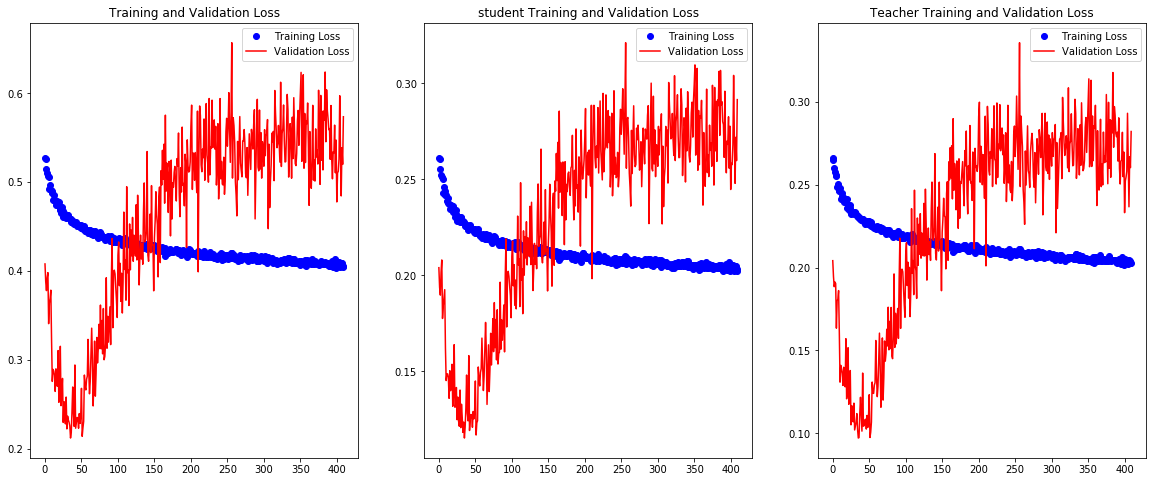

In [35]:
show_history(history, epochs)

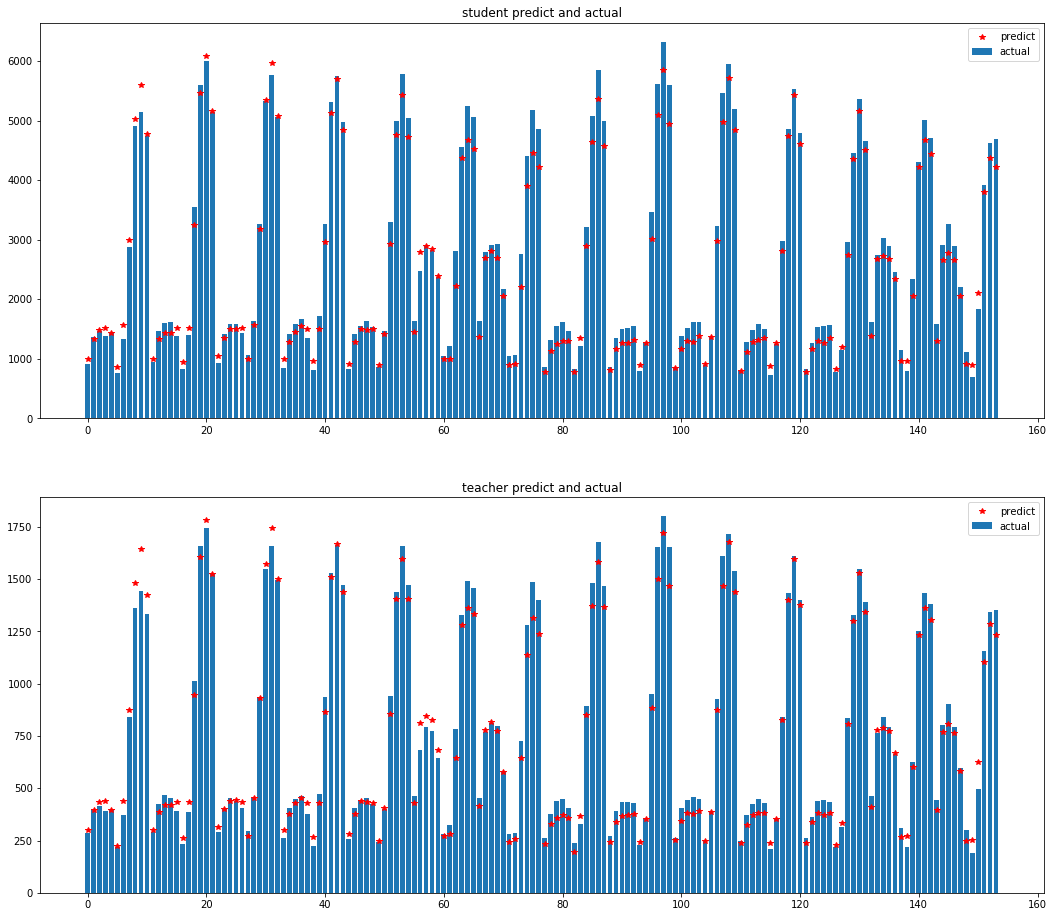

In [39]:
index = 154
show_data = sample.iloc[-index:, 2:].values
a = model.predict(show_data)
a[0] = a[0] * student_std + student_mean
a[1] = a[1] * teacher_std + teacher_mean 
validation_student_v = data.student_count.iloc[-index:].values
validation_teacher_v = data.teacher_count.iloc[-index:].values
show_predict(a, [validation_student_v,validation_teacher_v ])

## 下一周和本周预测

In [60]:
this_week = Week()
next_week = this_week.get_next_week()

In [63]:
this_week_slot_times = [slot.replace(tzinfo=None) for slot in this_week.slot_times]
this_week_df = pd.DataFrame(1, index=this_week_slot_times, columns=['student_count'])
c = this_week_df.student_count == 1
c[0:6] = False
c[11:17] = False
c[22:28] = False
c[33:39] = False
c[44:50] = False
this_week_df = this_week_df.loc[c]
this_week_df['teacher_count'] = 1

next_week_slot_times = [slot.replace(tzinfo=None) for slot in next_week.slot_times]
next_week_df = pd.DataFrame(1, index=next_week_slot_times, columns=['student_count'])
c = next_week_df.student_count == 1
c[0:6] = False
c[11:17] = False
c[22:28] = False
c[33:39] = False
c[44:50] = False
next_week_df = next_week_df.loc[c]
next_week_df['teacher_count'] = 1

In [65]:
all_data = pd.concat([data,this_week_df, next_week_df])

In [66]:
sample = process_data(all_data)

/Users/coffee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coffee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [67]:
next_sample = sample.loc['2020-06-01 00:00:00':]

In [68]:
next_sample.loc[:, 'active_student_cnt'] = [ wasc.loc[isoYW(i)] for i in next_sample.index]

/Users/coffee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
a = model.predict(next_sample.iloc[:, 2:].values)
a[0] = a[0] * student_std + student_mean
a[1] = a[1] * teacher_std + teacher_mean 
# validation_student_v = data.student_count.iloc[-index:].values
# validation_teacher_v = data.teacher_count.iloc[-index:].values
# show_predict(a, [validation_student_v,validation_teacher_v ])

In [71]:
output = pd.DataFrame(np.concatenate([a[0], a[1]], axis=1), index = next_sample.index, columns=['student', 'teacher'])

In [72]:
output

,student,teacher
2020-06-01 17:50:00,1521.550415,443.211182
2020-06-01 18:30:00,3424.163086,999.905762
2020-06-01 19:10:00,4186.484863,1228.350952
2020-06-01 19:50:00,4323.651855,1277.482300
2020-06-01 20:30:00,3863.100342,1135.399780
...,...,...
2020-06-14 17:50:00,753.595459,201.828369
2020-06-14 18:30:00,1709.514160,499.437103
2020-06-14 19:10:00,3100.153564,925.293396
2020-06-14 19:50:00,3566.924072,1063.056396


In [75]:
output.to_csv(f'teacher_predict_{week}.csv')

In [74]:
!pwd

/Users/coffee/Documents/jupyterLabSpace/jiuqu


-----

# 训练模型

In [7]:
from qkids.DatabasePool import get_odps
odps = get_odps()

In [8]:
students = odps.get_table('dwd_students').to_df()
students = students[students.registed_at.notnull()]
students['date'] = students.registed_at.strftime("%Y-%m-%d")
student_cnt_by_date = students.groupby('date').agg(count=students.date.count())
student_cnt_by_date = student_cnt_by_date.to_pandas()

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

In [9]:
student_cnt_by_date.set_index('date', inplace=True)

In [10]:
student_cnt_by_date_cumsum = student_cnt_by_date.cumsum()
student_cnt_by_date_cumsum = student_cnt_by_date_cumsum['2018-01-01':]

In [11]:
student_cnt_by_date_cumsum.to_pickle('student_cnt.pkl')
# student_cnt_by_date_cumsum = pd.read_pickle('student_cnt.pkl')

In [12]:
minmax = MinMaxScaler().fit_transform(student_cnt_by_date_cumsum.values)

In [13]:
minmax_users = pd.Series(minmax[:, 0], index = student_cnt_by_date_cumsum.index)

## 上课数据

In [14]:
dnn._df['ss'] = [ minmax_users.get(i.strftime("%Y-%m-%d"), 1) for i in dnn._df.index] 

In [15]:
split_day = '2020-04-13 00:00:00'
train, validation = dnn._df.loc[:split_day].values, dnn._df.loc[split_day:].values
train_student, validation_student = dnn.Y_student.loc[:split_day].values, dnn.Y_student.loc[split_day:].values
train_teacher, validation_teacher = dnn.Y_teacher.loc[:split_day].values, dnn.Y_teacher.loc[split_day:].values

In [16]:
data_input = tf.keras.Input(shape=[366 + 11+ 1 + 1], name='date')
layer = tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(data_input)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
student_predict_layer = tf.keras.layers.Dense(units=1, name='student')(layer)
teacher_predict_layer = tf.keras.layers.Dense(units=1, name='teacher')(layer)

api_model = tf.keras.models.Model(data_input, [student_predict_layer, teacher_predict_layer])

In [17]:
api_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = ['mae', 'mae'])

In [18]:
epochs = 1000 # 1050 + 100 + 100 + 100

In [19]:
history = api_model.fit(
    train, [train_student, train_teacher], epochs=epochs,
    validation_data=(validation, [validation_student, validation_teacher]),
    shuffle=True,verbose=False
)

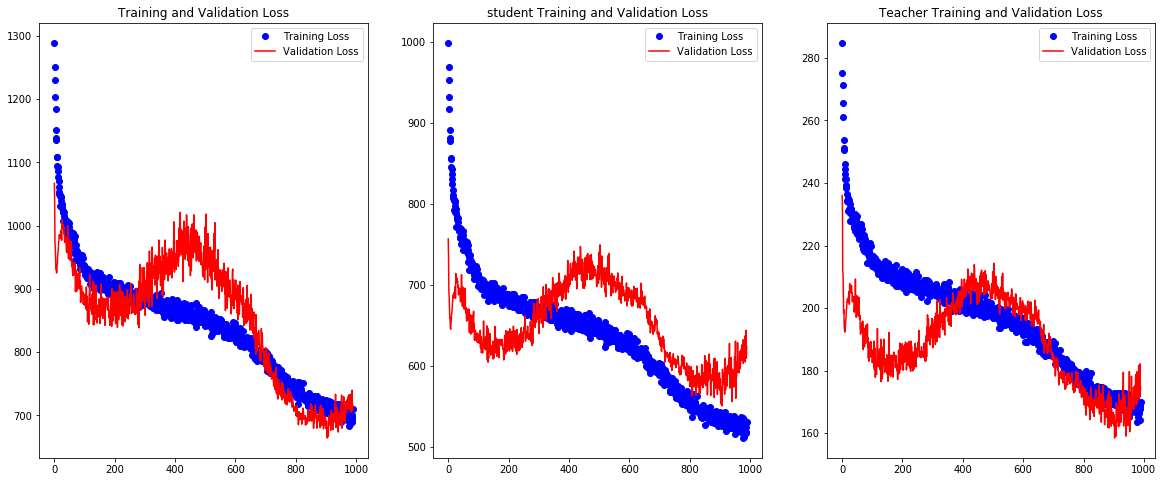

In [20]:
show_history(history, epochs)

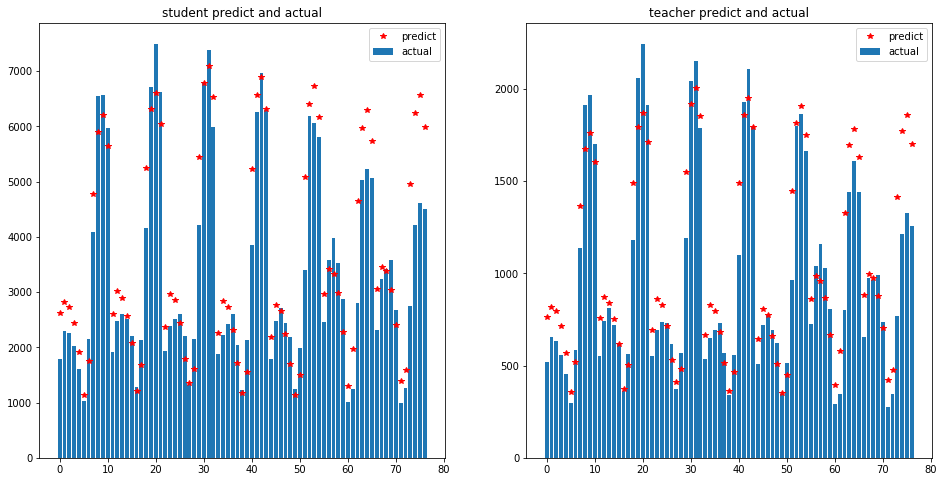

In [21]:
a = api_model.predict(validation)
show_predict(a, [validation_student,validation_teacher ])

## 只训练老师

In [37]:
data_input = tf.keras.Input(shape=[366 + 11+ 1 + 1], name='date')
layer = tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(data_input)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
teacher_predict_layer = tf.keras.layers.Dense(units=1, name='teacher')(layer)

api_model = tf.keras.models.Model(data_input, teacher_predict_layer)

In [38]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=100)
]

In [39]:
api_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = 'mae')

In [40]:
epochs = 1000 # 500 + 300 + 300 + 300 || 500 + 300 + 170

In [41]:
history = api_model.fit(
    train, train_teacher, epochs=epochs,
    validation_data=(validation, validation_teacher),
#     callbacks=callbacks_list,
    shuffle=True,verbose=False
)

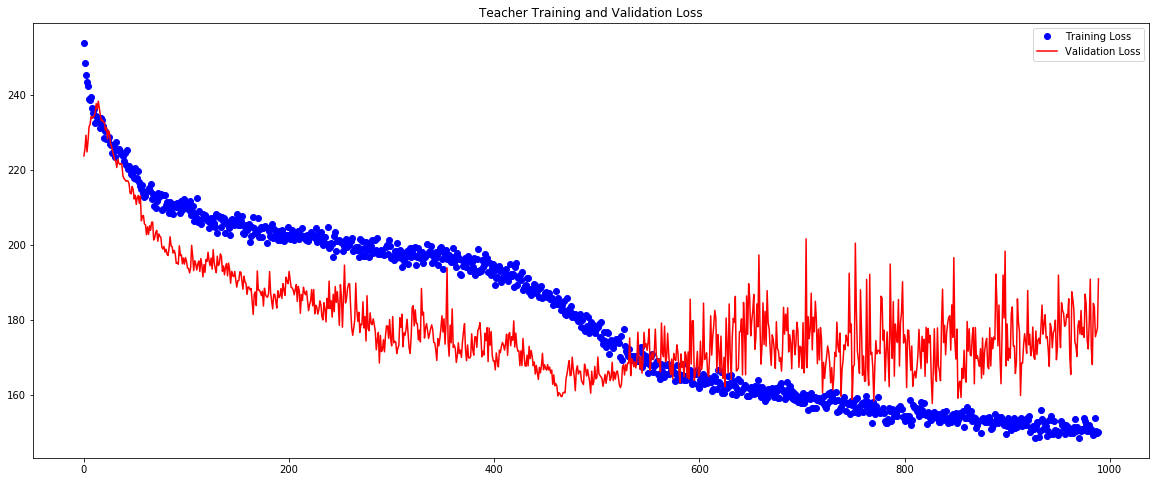

In [42]:
show_history_teacher(history)

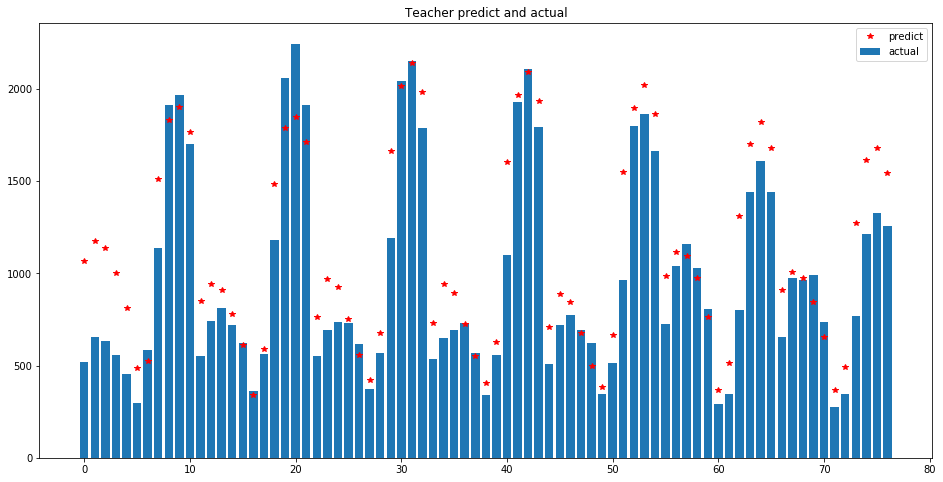

In [43]:
show_predict_teacher(api_model.predict(validation), validation_teacher)

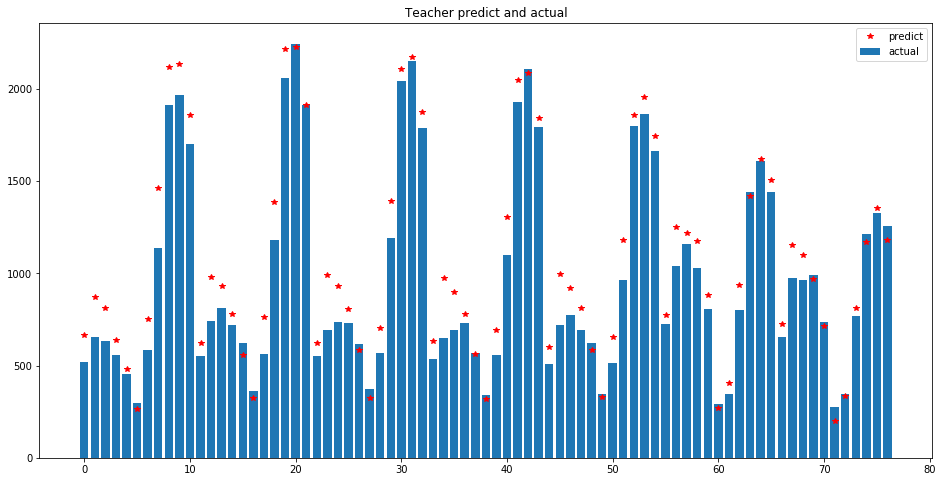

In [29]:
#  前一周 的mae
last_week_teacher_cnt = dnn.Y_teacher['2020-04-06 00:00:00': split_day]
show_predict_teacher(last_week_teacher_cnt.to_numpy(), validation_teacher)

In [25]:
X = dnn._df.values
Y2 = dnn.Y_teacher.values

In [26]:
history = api_model.fit(
    X, Y2, epochs=epochs,
    validation_data=(validation, validation_teacher),
    callbacks=callbacks_list,
    shuffle=True,verbose=False
)

In [31]:
api_model.save('schedule.h5')

In [59]:
model.save_weights('checkpoints/t1')

## 加验证数据输出

In [44]:
X = dnn._df.values
Y1 = dnn.Y_student.values
Y2 = dnn.Y_teacher.values

In [48]:
out_model = tf.keras.models.Model(data_input,  teacher_predict_layer)
out_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss = 'mae')

In [49]:
epochs = 600

In [50]:
history = out_model.fit(
    X, Y2, epochs=epochs,
    shuffle=False,verbose=False
)

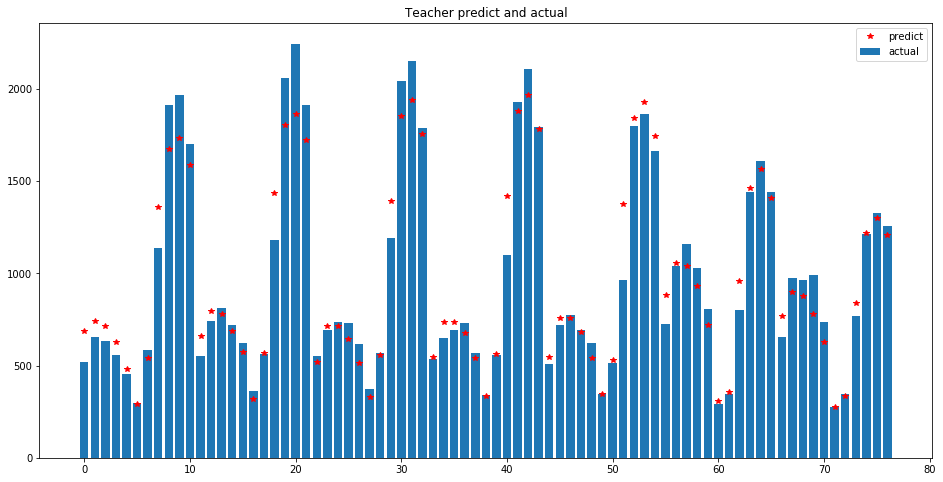

In [52]:
show_predict_teacher(out_model.predict(validation), validation_teacher)

Text(0.5, 1.0, 'Teacher predict and actual')

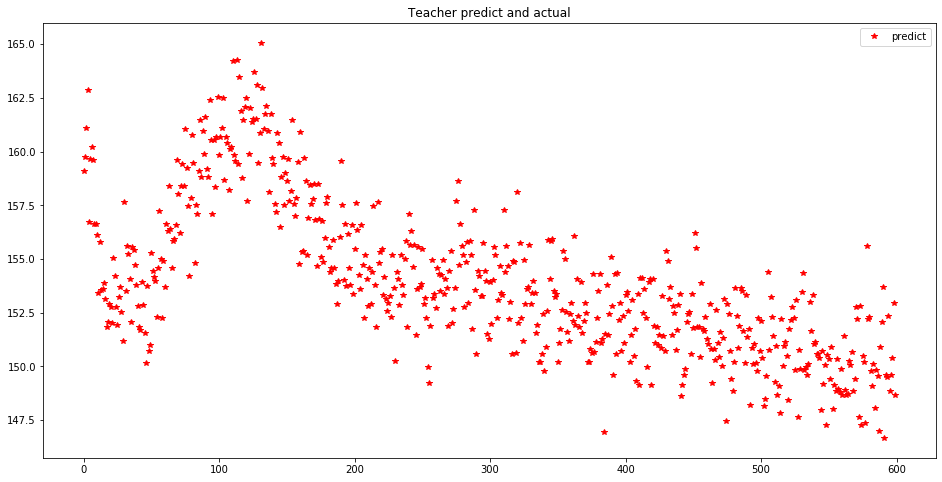

In [56]:
predict = history.history['loss']
plt.figure(1, figsize=(16, 8))
length = range(len(predict))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(length, predict, 'r*', label='predict')
ax1.legend(loc='upper right')
ax1.set_title('Teacher predict and actual')

In [57]:
out_model.save('schedule.h5')